In [1]:
import torchvision.transforms
import source.data
import source.utils
import torch.hub
import torch.utils.data
import torch
import torch.optim
_  = torch.manual_seed(0)
cpu_device = torch.device('cpu')
device = torch.device('cuda:0')
torch.cuda.empty_cache()
total_free_memory, total_memory = torch.cuda.mem_get_info() 
total_free_memory / 1000000000,  total_memory / 1000000000

(15.532294144, 15.640231936)

In [2]:
import source.modules


image_transform = torchvision.transforms.Compose(
    [
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((280, 280)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(lambda image_as_int_tensor: image_as_int_tensor / 255.),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((280, 280)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(
        lambda mask_as_int_tensor: mask_as_int_tensor.squeeze().type(torch.LongTensor)
    ),
])

dataset = source.data.PascalPartDataset(
    transform=image_transform,
    target_transform=mask_transform
)

dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=16)

backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

head = torch.nn.Sequential(
    torch.nn.Linear(384, 1225),

    source.modules.View((1, 35, 35)),

    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5, 5), padding=(2, 2)),
    torch.nn.BatchNorm2d(num_features=8),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.ReLU(),

    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=(2, 2)),
    torch.nn.BatchNorm2d(num_features=32),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.ReLU(),


    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5), padding=(2, 2)),
    torch.nn.BatchNorm2d(num_features=64),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.ReLU(),

    torch.nn.Conv2d(in_channels=128, out_channels=7, kernel_size=(1, 1)),
)

optimizer = torch.optim.AdamW(head.parameters(), lr=0.001)
loss_function = source.utils.FocalLoss(gamma=2)

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
_ = (
    backbone.to(device),
    loss_function.to(device),
    head.to(device)
)

In [4]:
metrics_tracker: dict[int, list[float]] = {index:[] for index in range(-1, 7)}
n_epochs = 50

for epoch in range(n_epochs):
    for iteration, (images, masks) in enumerate(dataloader):

        images = images.to(device)
        masks = masks.to(device)

        embeddings = backbone(images)
        logits = head(embeddings)

        loss_value = loss_function(
            logits,
            masks
        )

        intersection_over_union_per_class = source.utils.log_probabilities_and_mask_iou_per_class(
            log_probabilities=torch.nn.functional.log_softmax(logits, dim=1),
            masks=masks,
            classes=list(dataset.class_to_name.keys()),
        )

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        
        metrics_tracker[-1].append(loss_value.to(cpu_device).detach().item())
        for object_class in list(dataset.class_to_name.keys()):
            metrics_tracker[object_class].append(
                intersection_over_union_per_class[object_class][
                   intersection_over_union_per_class[object_class] >= 0. 
                ].mean().to(cpu_device).detach().item()
            )

        if iteration % 5 == 0:
            print(
                f"Iteration: {epoch * len(dataloader) + iteration}" +
                f"/ {n_epochs*len(dataloader)} "
                f"Loss value: {metrics_tracker[-1][-1]:.3f} \t ",
                "IoU - ",
                *[
                    f"{dataset.class_to_name[object_class]} : " +
                    f"{metrics_tracker[object_class][-1]:.3f} \t "
                    for object_class in list(dataset.class_to_name.keys())
                ]
            )

Iteration: 0/ 8850 Loss value: 1.399 	  IoU -  bg : 0.091 	  low_hand : 0.019 	  torso : 0.022 	  low_leg : 0.003 	  head : 0.035 	  up_leg : 0.019 	  up_hand : 0.001 	 
Iteration: 5/ 8850 Loss value: 0.703 	  IoU -  bg : 0.767 	  low_hand : 0.000 	  torso : 0.000 	  low_leg : 0.000 	  head : 0.000 	  up_leg : 0.000 	  up_hand : 0.000 	 
Iteration: 10/ 8850 Loss value: 0.602 	  IoU -  bg : 0.785 	  low_hand : 0.000 	  torso : 0.000 	  low_leg : 0.000 	  head : 0.000 	  up_leg : 0.000 	  up_hand : 0.000 	 
Iteration: 15/ 8850 Loss value: 0.519 	  IoU -  bg : 0.811 	  low_hand : 0.000 	  torso : 0.000 	  low_leg : 0.000 	  head : 0.000 	  up_leg : 0.000 	  up_hand : 0.000 	 
Iteration: 20/ 8850 Loss value: 0.511 	  IoU -  bg : 0.784 	  low_hand : 0.000 	  torso : 0.000 	  low_leg : 0.000 	  head : 0.000 	  up_leg : 0.000 	  up_hand : 0.000 	 
Iteration: 25/ 8850 Loss value: 0.492 	  IoU -  bg : 0.805 	  low_hand : 0.000 	  torso : 0.000 	  low_leg : 0.000 	  head : 0.000 	  up_leg : 0.00

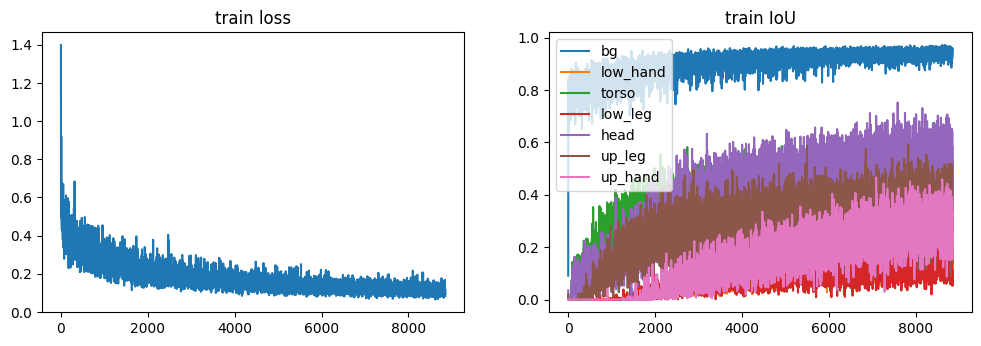

In [5]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(12, 8))

figure.add_subplot(2, 2, 1)
plt.plot(metrics_tracker[-1], label="")
plt.title("train loss")

figure.add_subplot(2, 2, 2)
[
    plt.plot(metrics_tracker[index], label=dataset.class_to_name[index])
    for index in range(0, 7)
]
plt.legend()
plt.title("train IoU")

plt.show()

# metrics on eval

In [6]:
evaluation_dataset = source.data.PascalPartDataset(
    transform=image_transform,
    train=False,
)
_ = backbone.eval(), head.eval()
evaluation_metrics_tracker = {index:[] for index in range(0, 7)}

In [7]:
with torch.no_grad():
    for image, mask in evaluation_dataset:
        image = image.to(device)
        mask = mask.to(device)
        
        mask_shape = mask.shape
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        embedding = backbone(image)
        logits = head(embedding)

        log_probabilities = torch.nn.functional.log_softmax(
            logits,
            dim=1, # 1 x C x H x W
        )
        upsampled_log_probabilities = torch.nn.functional.interpolate(
            input=log_probabilities,
            size=mask_shape,
        )

        intersection_over_union_per_class = source.utils.log_probabilities_and_mask_iou_per_class(
            log_probabilities=upsampled_log_probabilities,
            masks=mask,
            classes=list(dataset.class_to_name.keys()),
        )
        
        for object_class in list(dataset.class_to_name.keys()):
            evaluation_metrics_tracker[object_class].append(
                intersection_over_union_per_class[object_class].mean().to(cpu_device).item()
            )

print(
    "IoU - ",
    *[
        f"{evaluation_dataset.class_to_name[object_class]} : " +
        f"{sum(evaluation_metrics_tracker[object_class]) / len(evaluation_metrics_tracker[object_class]):.3f} \t "
        for object_class in list(evaluation_dataset.class_to_name.keys())
    ]
)

IoU -  bg : 0.759 	  low_hand : 0.018 	  torso : 0.108 	  low_leg : 0.009 	  head : 0.092 	  up_leg : 0.021 	  up_hand : 0.030 	 


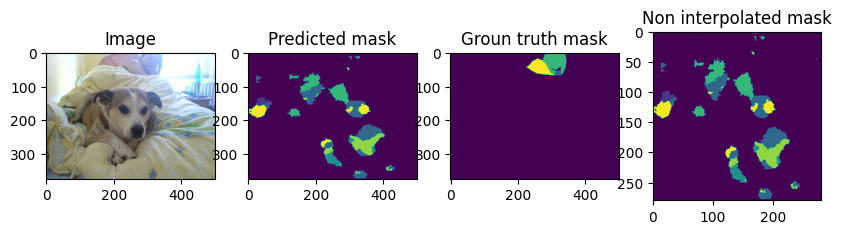

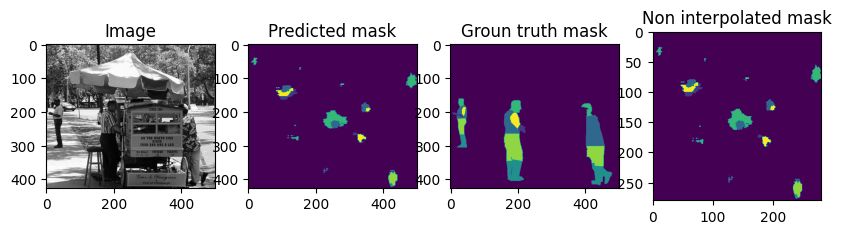

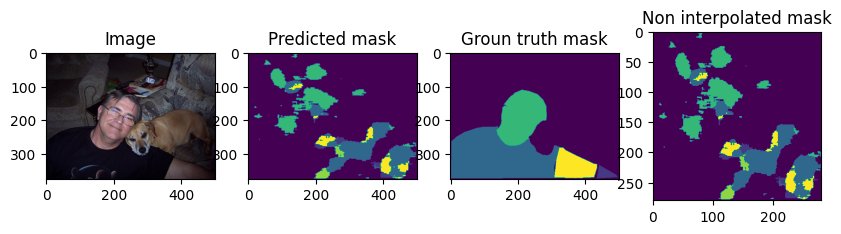

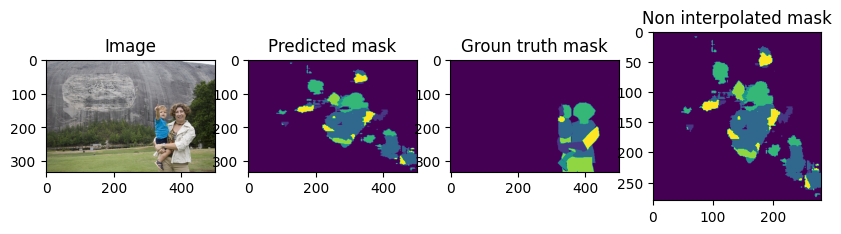

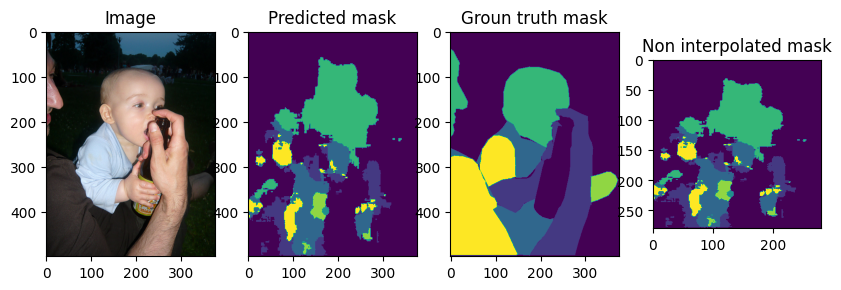

In [9]:
for _ in range(5):
    random_index = torch.randint(0, len(evaluation_dataset), size=(1, )).item()
    original_image, original_mask = source.data.PascalPartDataset(train=False)[random_index]
    mask_shape = original_mask.shape
    image = image_transform(original_image).unsqueeze(0)
    mask = mask.unsqueeze(0)

    image = image.to(device)
    embedding = backbone(image)
    logits = head(embedding)

    log_probabilities = torch.nn.functional.log_softmax(
        logits,
        dim=1, # 1 x C x H x W
    )
    upsampled_log_probabilities = torch.nn.functional.interpolate(
        input=log_probabilities,
        size=mask_shape,
    )
    predicted_mask = upsampled_log_probabilities.argmax(
        dim=1
    ).squeeze().to(cpu_device)

    figure = plt.figure(figsize=(10, 4))

    figure.add_subplot(1, 4, 1)
    plt.imshow(original_image.squeeze().permute(1, 2, 0))
    plt.title("Image")

    figure.add_subplot(1, 4, 2)
    plt.imshow(predicted_mask)
    plt.title("Predicted mask")

    figure.add_subplot(1, 4, 3)
    plt.imshow(original_mask.squeeze())
    plt.title("Groun truth mask")

    figure.add_subplot(1, 4, 4)
    plt.imshow(log_probabilities.argmax(
        dim=1
    ).squeeze().to(cpu_device))
    plt.title("Non interpolated mask")

    plt.show()

# Results of experiments: